# Project 4: Whale Calls



## Descripción general


**Conjunto de datos:** Llamados de ballenas para prevenir colisiones
El problema es clasificar un caso como ballena franca o no basándose en una señal de audio. Esos casos positivos contienen un conjunto de llamados ascendentes de ballena franca. Los llamados ascendentes son la vocalización de ballena franca más comúnmente documentada con una firma acústica de aproximadamente 60 Hz a 250 Hz, que generalmente dura 1 segundo. Cada serie está etiquetada como que contiene una ballena franca o no con el objetivo de identificar correctamente la serie que contiene llamados ascendentes. Los llamados de ballena franca a menudo pueden ser difíciles de escuchar ya que la banda de baja frecuencia puede congestionarse con sonidos antropogénicos como ruido de barcos, perforaciones, pilotes u operaciones navales.

Cada caso es un segmento de audio de dos segundos muestreado a 2 kHz, lo que da una longitud de serie de 4000.

**Instrucciones**


*   Analice y extraiga las características del conjunto de datos pertinentes al problema que seleccionó en el paso anterior. Justifique sus decisiones.
*   Elige al menos dos métodos (incluido al menos uno aprendido en clase) para resolver el desafío propuesto que seleccionaste. Justifica tus decisiones.
*   Informar las métricas adecuadas. Analizar y discutir los resultados de cada método.


## Importar librerias

In [ ]:
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import cvxopt
import seaborn as sns
import itertools
import os
import librosa
from IPython.display import Audio
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import math, os, torchvision, torch
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/DataSet/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

Probando la apertura de algunos archivos .wav

In [ ]:
y, sr = librosa.load(path + "train/0.wav" )
mfccs = librosa.feature.mfcc(y=y, sr=sr)
feacture_vector = np.array(mfccs.mean(axis = 1))
print("Feacture Vector of the Whale sound:" , feacture_vector)
Audio(data=y, rate=sr)


Feacture Vector of the Whale sound: [-6.6629205e+02  2.0302626e+02  1.2296489e+02  3.2377563e+01
 -3.5245567e+01 -5.9178642e+01 -4.2848377e+01 -7.9783320e+00
  1.9905506e+01  2.6018074e+01  1.1994647e+01 -8.6099272e+00
 -2.1085217e+01 -1.8900064e+01 -6.1726551e+00  7.0471926e+00
  1.2376251e+01  8.2582674e+00 -3.5707486e-01 -6.6166401e+00]


Extrayendo labels del csv a un diccionario

In [ ]:
df = pd.read_csv(path + 'train.csv', header=None) # Convertir el DataFrame en un diccionario
data_dict = dict(zip(df.iloc[1:, 0], df.iloc[1:, 1]))
mapping = {'NoWhale': 0, 'RightWhale': 1} # Nuevo diccionario con los valores convertidos
converted_dict = {k: mapping[v] for k, v in data_dict.items()}
print(converted_dict)

In [ ]:
def encode(path, data_type='train/'):
    data1 = []
    labels = []
    directory_1 = os.listdir(path + data_type)
    for f in directory_1:
        y, sr = librosa.load(path + data_type + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        data1.append(mfccs.T)  # Transponer para obtener la forma correcta
        labels.append(converted_dict[f.split('.')[0]])
    data = np.array(data1)
    labels = np.array(labels)
    return data, labels

In [ ]:
def encode2(path, data_type='test/'):
    data1 = []
    filenames = []
    directory_1 = os.listdir(path + data_type)
    for f in directory_1:
        y, sr = librosa.load(path + data_type + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        data1.append(mfccs.T)  # Transponer para obtener la forma correcta
        filenames.append(f)
    data = np.array(data1)
    return data, filenames

## Data Train and Data Test

In [ ]:
x_train,y_train = encode(path, data_type= 'train/')

In [ ]:
x_test, test_filenames = encode2(path, data_type='test/')

In [ ]:
print(x_train.shape)  # Debería ser (num_samples, sequence_length, input_size)
print(y_train.shape)
print(x_test.shape)

(10309, 87, 20)
(10309,)
(1962, 87, 20)


## Métodos

In [ ]:
class WhaleDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.features[idx], dtype=torch.float32)


Crear los DataLoaders:

In [ ]:
X_train=x_train[:8000]
X_prueba=x_train[8000:]
Y_train=y_train[:8000]
Y_prueba=y_train[8000:]
train_dataset = WhaleDataset(X_train, Y_train)
prueba_dataset=WhaleDataset(X_prueba,Y_prueba)
test_dataset = WhaleDataset(x_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
prueba_loader=DataLoader(prueba_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(prueba_loader))
print(len(test_loader))

250
73
62


In [ ]:
# Clase LSTM para clasificación binaria de audios
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Definir la capa LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Definir la capa lineal
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Inicializar los estados ocultos y de celda
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Paso del tensor de entrada a través de la LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Obtener la salida de la última celda de la secuencia (último paso temporal)
        out = self.fc(out[:, -1, :])

        # Retorno de la salida final
        return out

# Parámetros del modelo
input_size = 20  # Número de coeficientes MFCC
hidden_size = 128  # Tamaño de la capa oculta
num_layers = 5  # Número de capas LSTM
output_size = 1  # Salida binaria (0 o 1)

# Crear una instancia del modelo LSTM
model = LSTM(input_size, hidden_size, num_layers, output_size)


'''
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        _, (h_out, _) = self.rnn(window, (h0, c0))
        h_out = h_out[-1, :, :]
        out = self.fc(h_out)
        return out

input_size = x_train.shape[2]  # Número de coeficientes MFCC
hidden_size = 128
#output_size = 2  # Dos clases: NoWhale y RightWhale
num_layers = 1
model = LSTM(input_size, hidden_size, num_layers).to(device)

'''

'\nclass LSTM(nn.Module):\n    def __init__(self, input_size, hidden_size, num_layers):\n        super(LSTM, self).__init__()\n        self.hidden_size = hidden_size\n        self.num_layers = num_layers\n        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)\n        self.fc = nn.Linear(hidden_size, 1)\n\n    def forward(self, x):\n        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)\n        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)\n\n        _, (h_out, _) = self.rnn(window, (h0, c0))\n        h_out = h_out[-1, :, :]\n        out = self.fc(h_out)\n        return out\n\ninput_size = x_train.shape[2]  # Número de coeficientes MFCC\nhidden_size = 128\n#output_size = 2  # Dos clases: NoWhale y RightWhale\nnum_layers = 1\nmodel = LSTM(input_size, hidden_size, num_layers).to(device)\n\n'

In [ ]:
#criterion = nn.BCEWithLogitsLoss()
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for features in test_loader:
        features = features.to(device)
        outputs = model(features)
        predicted = torch.round(torch.sigmoid(outputs.squeeze()))
        predictions.extend(predicted.cpu().numpy())

# Mapear las predicciones a las etiquetas originales
label_mapping = {0: 'NoWhale', 1: 'RightWhale'}
predicted_labels = [label_mapping[pred] for pred in predictions]

# Crear un DataFrame con los índices y las predicciones
submission_df = pd.DataFrame({
    'idx': list(range(len(predicted_labels))),
    'class': predicted_labels
})

# Guardar el DataFrame en un archivo CSV
submission_df.to_csv('predictions.csv', index=False)
print("Predicciones guardadas en predictions.csv")


In [ ]:
# Evaluación del modelo
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in prueba_loader:
        features, labels = features.to(device), labels.to(device).float()
        outputs = model(features)
        predicted = torch.round(torch.sigmoid(outputs.squeeze()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the training set: {100 * correct / total:.2f}%')

Accuracy of the model on the training set: 50.97%


## Métricas

# Gráficas 📊

**Graficas** (Train dataset)

0    5467
1    5467
Name: count, dtype: int64


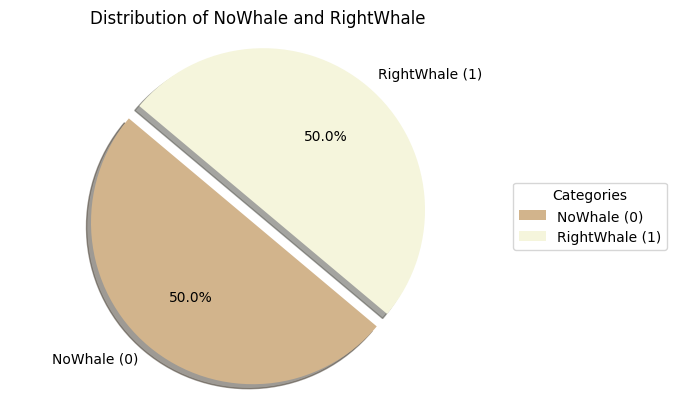

In [ ]:
# Recontar los valores de 0 y 1
value_counts = pd.Series(converted_dict.values()).value_counts()
print(value_counts)

labels = ['NoWhale (0)', 'RightWhale (1)']
sizes = [value_counts[0], value_counts[1]]
colors = ['Tan', 'beige']
explode = (0.1, 0)
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

ax.legend(wedges, labels,
          title="Categories",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')
plt.title('Distribution of NoWhale and RightWhale')
plt.show()

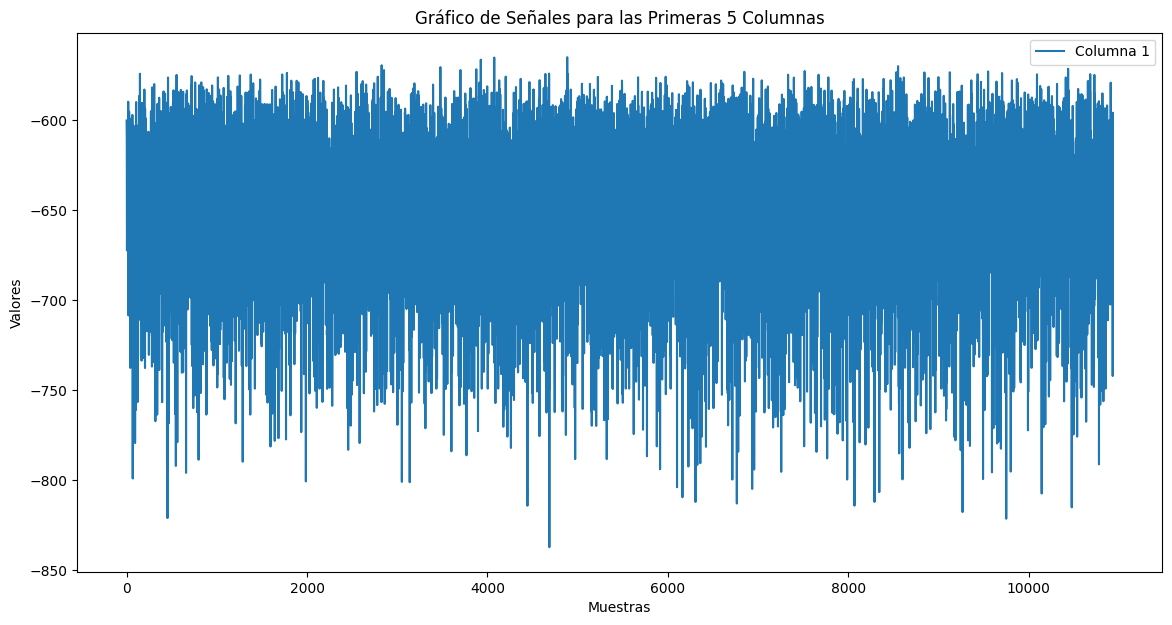

In [ ]:
# Gráfico de los primer feature de la matriz x_train
plt.figure(figsize=(14, 7))
for i in range(1):  # Iteramos sobre las primeras 5 columnas
    plt.plot(np.arange(x_train.shape[0]), x_train[:, i], label=f'Columna {i+1}')
plt.title('Gráfico de Señales para las Primeras 5 Columnas en x_train')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.legend()
plt.show()

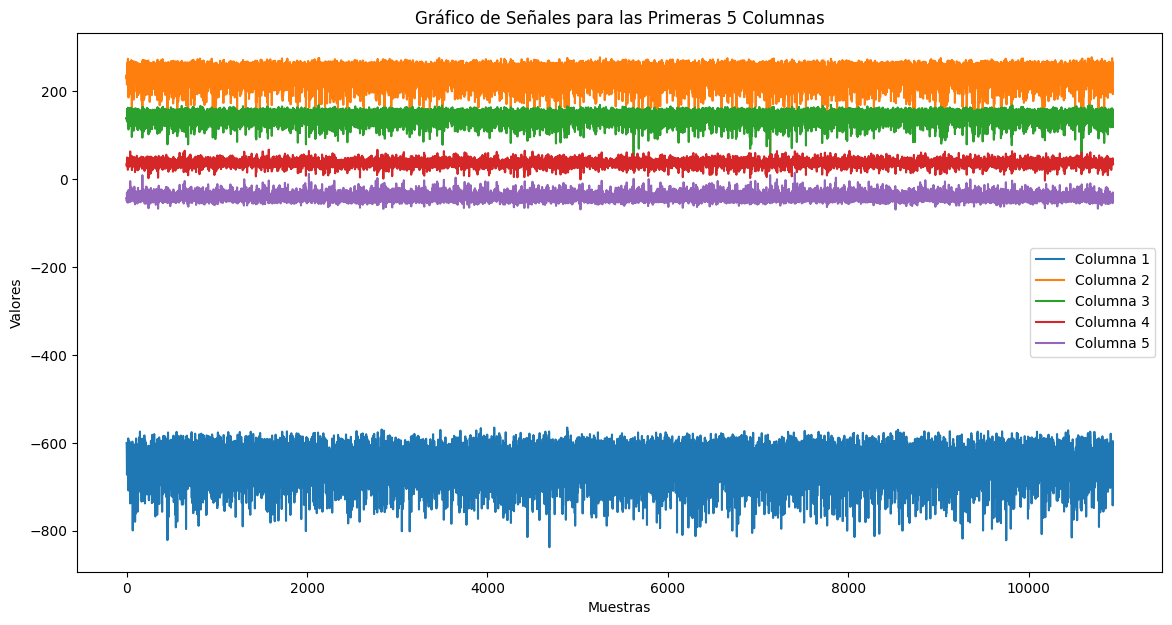

In [ ]:
# Gráfico de los primeros 5 features de la matriz x_train
plt.figure(figsize=(14, 7))
for i in range(5):  # Iteramos sobre las primeras 5 columnas
    plt.plot(np.arange(x_train.shape[0]), x_train[:, i], label=f'Columna {i+1}')
plt.title('Gráfico de Señales para las Primeras 5 Columnas en x_train')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.legend()
plt.show()

1
[-600.096      234.25362    139.46518     34.31441    -42.56482
  -69.03463    -50.098225   -11.511889    17.651894    21.978466
    5.2119484  -16.145966   -26.173805   -19.922739    -4.579461
    7.4629664    8.004723    -1.7313035  -13.392649   -18.404114 ]


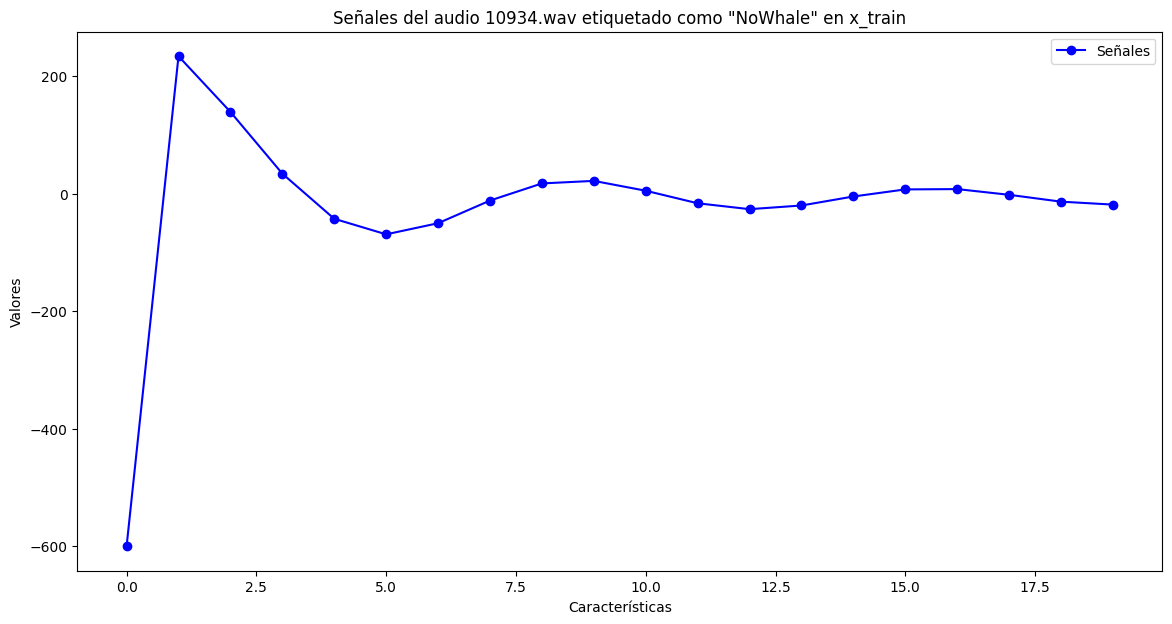

In [ ]:
#Grafico que muestra las señales de un audio 10934.wav donde este etiqeutado como ballena NoWhale
print(y_train[0])

print(x_train[0])
# Datos del primer audio etiquetado como "NoWhale"
audio_data = x_train[0]

# Graficar las señales del primer audio
plt.figure(figsize=(14, 7))
plt.plot(range(len(audio_data)), audio_data, marker='o', linestyle='-', color='b', label='Señales')
plt.title('Señales del audio 10934.wav etiquetado como "NoWhale" en x_train')
plt.xlabel('Características')
plt.ylabel('Valores')
plt.legend()
plt.grid(False)
plt.show()

1
[-670.50775    207.45226    126.975365    34.112316   -34.134777
  -57.80968    -40.33026     -2.8260617   29.009327    38.706917
   26.065315     3.791874   -12.861762   -15.7741995   -7.1759596
    4.0897017    9.599121     6.7453594   -0.710423    -6.5099993]


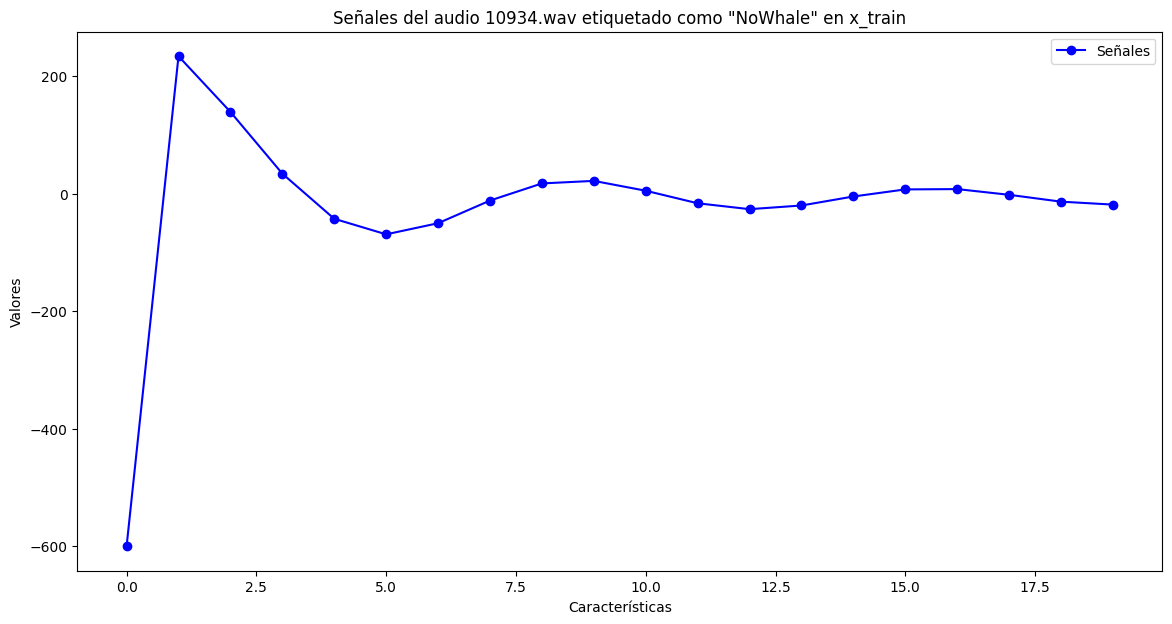

In [ ]:
#Grafico que muestra las señales de un audio 10934.wav donde este etiqeutado como ballena NoWhale
print(y_train[0])

print(x_train[10933])
# Datos del primer audio etiquetado como "NoWhale"
audio_data = x_train[0]

# Graficar las señales del primer audio
plt.figure(figsize=(14, 7))
plt.plot(range(len(audio_data)), audio_data, marker='o', linestyle='-', color='b', label='Señales')
plt.title('Señales del audio 10934.wav etiquetado como "NoWhale" en x_train')
plt.xlabel('Características')
plt.ylabel('Valores')
plt.legend()
plt.grid(False)
plt.show()

## x_test

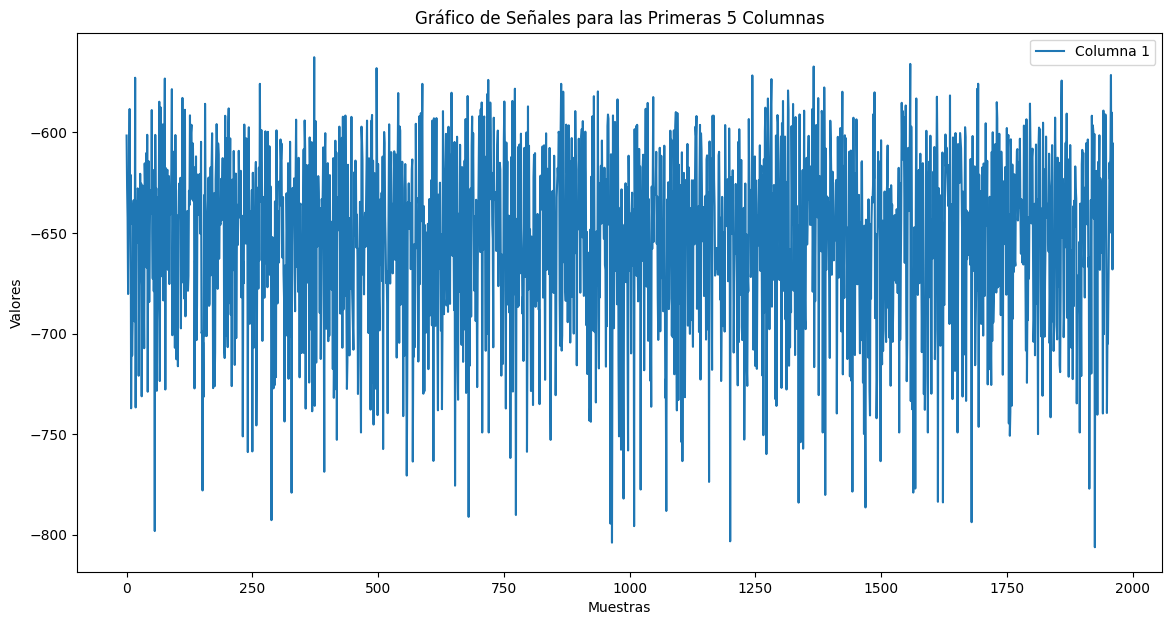

In [ ]:
# Gráfico de los primer feature de la matriz x_train
plt.figure(figsize=(14, 7))
for i in range(1):  # Iteramos sobre las primeras 5 columnas
    plt.plot(np.arange(x_test.shape[0]), x_test[:, i], label=f'Columna {i+1}')
plt.title('Gráfico de Señales para las Primeras 5 Columnas de x_test')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.legend()
plt.show()

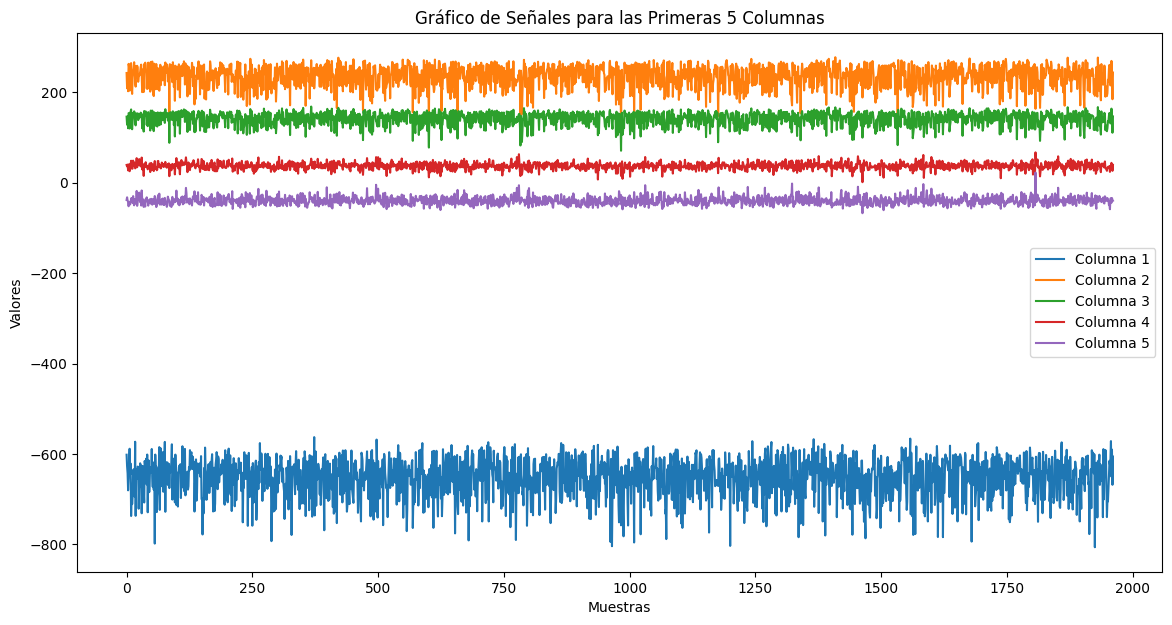

In [ ]:
# Gráfico de los primeros 5 features de la matriz x_test
plt.figure(figsize=(14, 7))
for i in range(5):  # Iteramos sobre las primeras 5 columnas
    plt.plot(np.arange(x_test.shape[0]), x_test[:, i], label=f'Columna {i+1}')
plt.title('Gráfico de Señales para las Primeras 5 Columnas de x_test')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.legend()
plt.show()

[-6.0159521e+02  2.4275157e+02  1.4611037e+02  3.9292805e+01
 -3.8122192e+01 -6.3725765e+01 -4.3603447e+01 -4.8592296e+00
  2.2950304e+01  2.4780279e+01  5.5631680e+00 -1.7119589e+01
 -2.7169092e+01 -2.0151810e+01 -4.1100378e+00  8.1299772e+00
  8.7162943e+00 -5.3103709e-01 -1.0962537e+01 -1.4437950e+01]


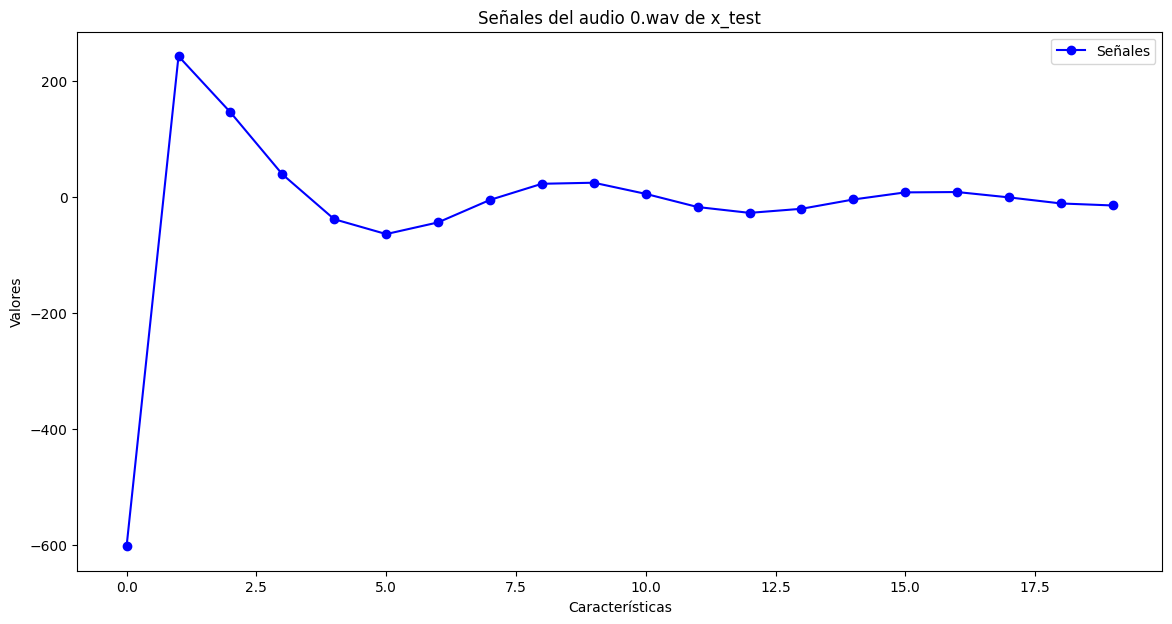

In [ ]:
#Grafico que muestra las señales de un audio 0.wav donde este etiqeutado como ballena NoWhale
print(x_test[0])
# Datos del primer audio etiquetado como "NoWhale"
audio_data = x_test[0]

# Graficar las señales del primer audio
plt.figure(figsize=(14, 7))
plt.plot(range(len(audio_data)), audio_data, marker='o', linestyle='-', color='b', label='Señales')
plt.title('Señales del audio 0.wav de x_test')
plt.xlabel('Características')
plt.ylabel('Valores')
plt.legend()
plt.grid(False)
plt.show()

[-605.6328     243.78273    146.6792      39.582104   -39.75681
  -68.42864    -50.99175    -13.261159    15.530476    19.552423
    2.4080257  -19.571032   -30.208914   -24.093744    -8.245609
    4.949141     6.968863    -1.5239674  -12.622128   -17.872633 ]


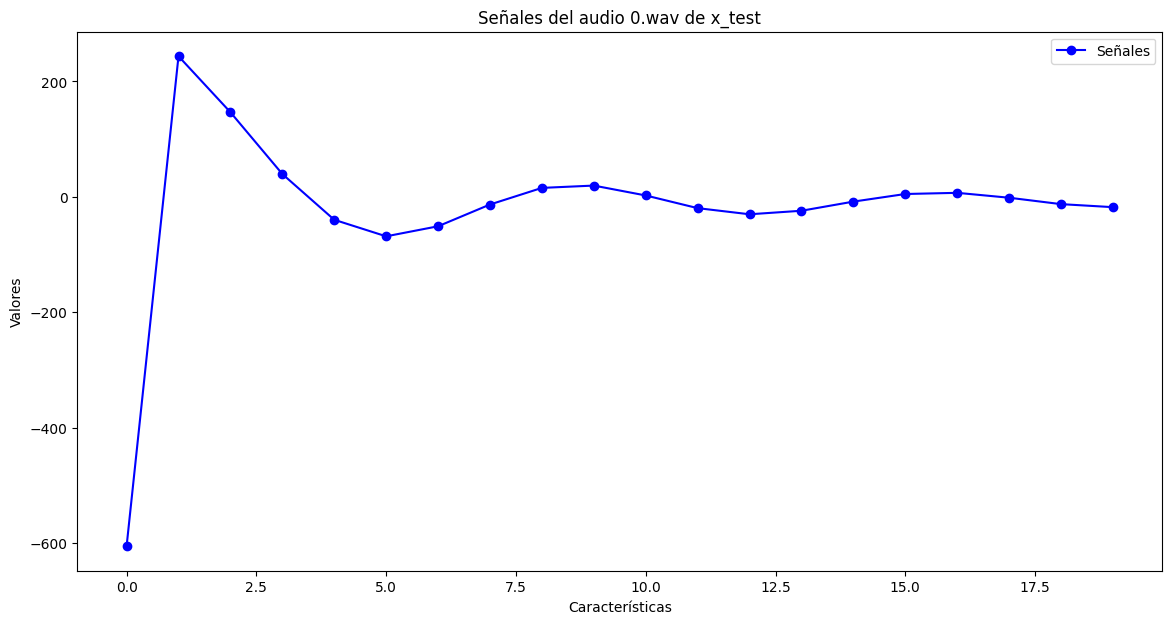

In [ ]:
#Grafico que muestra las señales de un audio 1962.wav donde este etiqeutado como ballena NoWhale
print(x_test[1961])
# Datos del primer audio etiquetado como "NoWhale"
audio_data = x_test[1961]

# Graficar las señales del ultimo audio
plt.figure(figsize=(14, 7))
plt.plot(range(len(audio_data)), audio_data, marker='o', linestyle='-', color='b', label='Señales')
plt.title('Señales del audio 1962.wav de x_test')
plt.xlabel('Características')
plt.ylabel('Valores')
plt.legend()
plt.grid(False)
plt.show()

#Nuevo modelo LSTM

In [ ]:
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import cvxopt
import seaborn as sns
import itertools
import pywt
import os
import librosa
from IPython.display import Audio
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import math, os, torchvision, torch
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/MLP4/Proyecto 4/Dataset/'


In [ ]:
def encode(path, data_type = 'train'):
  data1 = []
  labels = []
  directory_1 = os.listdir(path + data_type)
  print(directory_1)
  i = 0
  for f  in directory_1:
    y, sr = librosa.load(path +  data_type + f)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    fv = mfccs.mean(axis = 1)
    data1.append(fv)
    labels.append(converted_dict[f.split('.')[0]])
    print(i)
    print(f)
    i=i+1
  data = np.array(data1)
  # Important: Here the label is added; in this case, it is 1, but it may vary according to your requirements.
  #data = np.concatenate((data, temp), axis=0)
  #np.random.shuffle(data)
  labels = np.array(labels)
  #y = data[:,0]
  #x = data[:, 1:]
  return data, labels

In [ ]:
def encode2(path, data_type = 'test'):
  data1 = []
  directory_1 = os.listdir(path + data_type)
  print(directory_1)
  i = 0
  for f  in directory_1:
    y, sr = librosa.load(path +  data_type + f)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    fv = mfccs.mean(axis = 1)
    data1.append(fv)
    print(i)
    print(f)
    i=i+1
  data = np.array(data1)
  return data